# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
import numpy as np
import math
import re
import pandas as pd
import collections
import zipfile
import numpy as np
import jieba
from itertools import chain
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

-------------------------

### Stage 2: Data Preprocessing

#### (1) Read file 

In [2]:
df = pd.read_csv('data/Pork Bill - LY.csv',encoding='utf-8')
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])
data = df[['text', 'pork_bill']]

In [3]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # 首先分割 英文 以及英文和标点
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # 分割中文
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

# import spacy
# # python3 -m spacy download zh_core_web_sm
# spacy_nlp = spacy.load("zh_core_web_sm")

# data_clean = [clearPucts(text) for text in data.text]
# data_clean = [[spacy_nlp(sentence).vector for sentence in data] for data in data_clean]


#### (2) Tokenization

In [4]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [5]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)


#### (4) Spliting Training/Testing Set

In [6]:
data_labels = data.pork_bill.values

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test: ", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test: ", test_labels.shape )

Shape of X Train: (797, 123) 
Shape of X Test:  (394, 123) 
Shape of Y Trian: (797,) 
Shape of Y Test:  (394,)


-------------------------


### Stage 3: Model Specification and Building

#### (1) Build the Model

In [8]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, 
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, 
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output


In [9]:
VOCAB_SIZE = 1819 # tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
NB_EPOCHS = 150

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [10]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (123 , EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  363800    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  77056     
_________________________________________________________________
dropout (Dropout)            multiple                  0      

#### (3) Check Point Path

In [11]:
checkpoint_path = "./drive/My Drive/projects/CNN_for_NLP/ckpt/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

Latest checkpoint restored!!


-------------------------

### Stage 4: Train the Model

In [12]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [13]:
Dcnn.fit(train_inputs,
         train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop])
ckpt_manager.save()

Epoch 1/150
25/25 [==============================] - 2s 40ms/step - loss: 0.0023 - accuracy: 0.9987 - val_loss: 0.4574 - val_accuracy: 0.9137
Epoch 2/150
25/25 [==============================] - 1s 35ms/step - loss: 0.0017 - accuracy: 0.9987 - val_loss: 0.4601 - val_accuracy: 0.9162
Epoch 3/150
25/25 [==============================] - 1s 35ms/step - loss: 0.0027 - accuracy: 0.9987 - val_loss: 0.4618 - val_accuracy: 0.9162
Epoch 4/150
25/25 [==============================] - 1s 35ms/step - loss: 0.0020 - accuracy: 0.9975 - val_loss: 0.4626 - val_accuracy: 0.9137
Epoch 5/150
25/25 [==============================] - 1s 35ms/step - loss: 0.0019 - accuracy: 0.9987 - val_loss: 0.4666 - val_accuracy: 0.9137
Epoch 6/150
25/25 [==============================] - 1s 35ms/step - loss: 0.0021 - accuracy: 0.9987 - val_loss: 0.4728 - val_accuracy: 0.9162


'./drive/My Drive/projects/CNN_for_NLP/ckpt/ckpt-7'

-------------------------

### Stage 5: Evaluation

In [14]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.002286,0.998745,0.457428,0.913706
1,0.001730,0.998745,0.460063,0.916244
2,0.002705,0.998745,0.461760,0.916244
3,0.001962,0.997491,0.462597,0.913706
4,0.001881,0.998745,0.466569,0.913706
5,0.002123,0.998745,0.472847,0.916244


In [15]:
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

13/13 [==============================] - 0s 5ms/step - loss: 0.4728 - accuracy: 0.9162
[0.4728468358516693, 0.9162436723709106]


<AxesSubplot:>

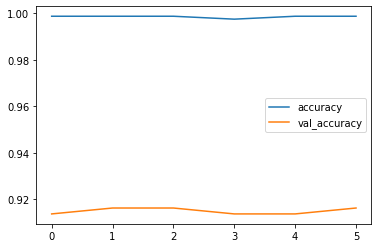

In [16]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

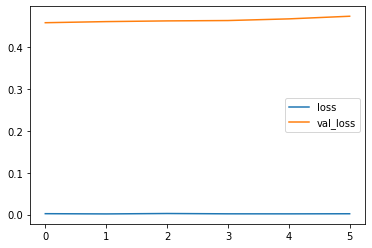

In [17]:
losses[['loss','val_loss']].plot()

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       265
           1       0.91      0.81      0.86       129

    accuracy                           0.91       394
   macro avg       0.91      0.89      0.90       394
weighted avg       0.91      0.91      0.91       394



In [19]:
pd.DataFrame(confusion_matrix(test_labels,predictions))

,0,1
0,255,10
1,24,105


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 200 samples from Leislative Questions

In [20]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [21]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/interpellation_ly_6th.csv')

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['title', 'topic']].reset_index(drop=True)

# randomly subsect 200 rows 
random.seed(4)
sample_df = LQ6.loc[random.sample(range(len(LQ6)), 200), ['title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]

In [22]:
pd.DataFrame(
    {'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}
).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(20)

,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
4546,0.863157272338867,針對諸多已獲得五年五百億與卓越計畫獎補助的大學擬調漲學雜費，但教育部長杜正勝曾承諾，獲得上述...,教育補助 ; 教育費用 ; 大學,卓越計畫獎補助 ; 大學學費
7720,0.693344533443451,針對內政部公告「低收入戶之資格家庭總收入以外財產總額之一定限額」有關不動產（土地及房屋）限額...,低收入戶 ; 不動產 ; 政府補助,低收入戶 ; 不動產 ; 低收入戶補助
4594,0.466114103794098,針對目前政府十三萬臨時人員已依勞退新制提撥退休金，但仍尚未納入勞基法保障，政府應儘速公布將臨...,勞動基準 ; 聘僱人員 ; 法律適用範圍,臨時人員 ; 勞基法
8671,0.320997893810272,針對政府公教貸款利率高於一般商業銀行專案辦理之房屋貸款利率，使公教人員之房貸利息負擔沈重依舊...,公務員福利 ; 房屋貸款 ; 利率,公教貸款利率
840,0.294913262128830,針對台北縣板橋市大漢溪沿岸的環河道路，因道路寬窄不一，規劃不完善且無汽、機車分流，加上大型車...,交通安全 ; 道路工程,大漢溪 ; 環河道路
3589,0.267547190189362,針對內政部即將公布之「人口政策白皮書」，擬加碼發放育兒津貼，以獎勵生育。本席樂觀其成，惟希望...,人口政策,人口政策 ; 獎勵生育
8329,0.255806893110275,南投縣為農業縣份，工商不發達，稅收財源不豐裕，全年度自有財源收入尚不敷支應全縣人事費支出，而...,地方財政,稅收 ; 地方財政
5076,0.121789485216141,針對陳水扁身陷國務機要費案，為求自保以所指稱的六項外交工作資料，「屬於國家機密，不受國家機密...,國家元首 ; 偵查,國務機要費 ; 國家機密保護法
4919,0.048991501331329,針對民法第1059條子女改姓之規定，子女是否有於成年後依其自由意志更改姓氏之權利，特向行政院...,姓名,子女改姓
9150,0.033610731363297,針對近年來財務持續惡化的中央健康保險局，利用健保費給付銀行巨額借款利息表示斥責。健保局用民眾...,國民 ; 健康保險 ; 保險費,財務 ; 中央健康保險局 ; 健保費給付


#### (2) Export an End-to-end Model


In [23]:
from tensorflow.keras.models import load_model

In [ ]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('pork_model')

In [25]:
from tensorflow import keras
model = keras.models.load_model('pork_model')